## Import libraries

In [1]:
import yfinance as yf

from copy import deepcopy as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Download data

In [2]:
stock_data = yf.Ticker("AMZN").history(period="max")
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-13 00:00:00-04:00,186.089996,187.669998,182.669998,183.830002,39721500,0.0,0.0
2024-06-14 00:00:00-04:00,183.080002,183.720001,182.229996,183.660004,25456400,0.0,0.0
2024-06-17 00:00:00-04:00,182.520004,185.000000,181.220001,184.059998,35601900,0.0,0.0


In [3]:
stock_data['Date'] = stock_data.index
stock_data = stock_data[['Date', 'Close']]
stock_data = stock_data.reset_index(drop=True)
stock_data

,Date,Close
0,1997-05-15 00:00:00-04:00,0.097917
1,1997-05-16 00:00:00-04:00,0.086458
2,1997-05-19 00:00:00-04:00,0.085417
3,1997-05-20 00:00:00-04:00,0.081771
4,1997-05-21 00:00:00-04:00,0.071354
...,...,...
6814,2024-06-13 00:00:00-04:00,183.830002
6815,2024-06-14 00:00:00-04:00,183.660004
6816,2024-06-17 00:00:00-04:00,184.059998
6817,2024-06-18 00:00:00-04:00,182.809998


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<Axes: xlabel='Date'>

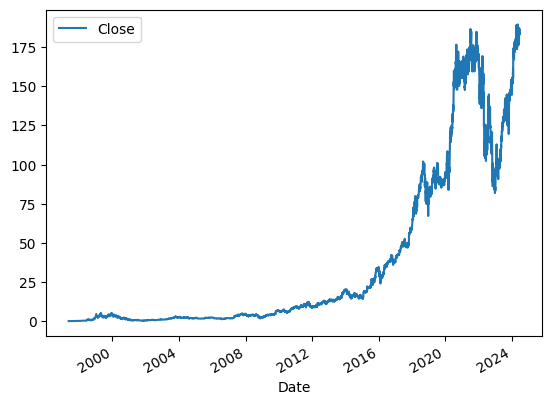

In [5]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.plot.line(x='Date', y='Close')

In [6]:
df = dc(stock_data)
df.set_index('Date', inplace=True)
df

,Close
Date,
1997-05-15 00:00:00-04:00,0.097917
1997-05-16 00:00:00-04:00,0.086458
1997-05-19 00:00:00-04:00,0.085417
1997-05-20 00:00:00-04:00,0.081771
1997-05-21 00:00:00-04:00,0.071354
...,...
2024-06-13 00:00:00-04:00,183.830002
2024-06-14 00:00:00-04:00,183.660004
2024-06-17 00:00:00-04:00,184.059998


## Create lookback columns

In [7]:
lookback = 7
for i in range(lookback):
    df[f'Close(t-{i + 1})'] = df['Close'].shift(i + 1)

df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-15 00:00:00-04:00,0.097917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16 00:00:00-04:00,0.086458,0.097917,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19 00:00:00-04:00,0.085417,0.086458,0.097917,NaN,NaN,NaN,NaN,NaN
1997-05-20 00:00:00-04:00,0.081771,0.085417,0.086458,0.097917,NaN,NaN,NaN,NaN
1997-05-21 00:00:00-04:00,0.071354,0.081771,0.085417,0.086458,0.097917,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-13 00:00:00-04:00,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996
2024-06-14 00:00:00-04:00,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999
2024-06-17 00:00:00-04:00,184.059998,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000


In [8]:
df.dropna(inplace=True)
df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27 00:00:00-04:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00-04:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00-04:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00-04:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00-04:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-06-13 00:00:00-04:00,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996
2024-06-14 00:00:00-04:00,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999
2024-06-17 00:00:00-04:00,184.059998,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000


In [9]:
data = df.to_numpy()
data

array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.84059998e+02, 1.83660004e+02, 1.83830002e+02, ...,
        1.87059998e+02, 1.84300003e+02, 1.85000000e+02],
       [1.82809998e+02, 1.84059998e+02, 1.83660004e+02, ...,
        1.87229996e+02, 1.87059998e+02, 1.84300003e+02],
       [1.86100006e+02, 1.82809998e+02, 1.84059998e+02, ...,
        1.86889999e+02, 1.87229996e+02, 1.87059998e+02]])

## Scale data to (-1, 1)

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

scaled_data

array([[-0.99991201, -0.999956  , -1.        , ..., -0.99983503,
        -0.99982404, -0.99970306],
       [-0.9999395 , -0.99991201, -0.99994501, ..., -0.99987353,
        -0.99983503, -0.99982404],
       [-0.99995326, -0.9999395 , -0.99990102, ..., -0.99998351,
        -0.99987353, -0.99983503],
       ...,
       [ 0.94256426,  0.93834111,  0.94013628, ...,  0.97423851,
         0.94509855,  0.9524891 ],
       [ 0.92936671,  0.94256426,  0.93834145, ...,  0.97603334,
         0.97423851,  0.94509855],
       [ 0.96410274,  0.92936671,  0.94256457, ...,  0.97244367,
         0.97603334,  0.97423851]])

In [11]:
x = scaled_data[:, 1:]
y = scaled_data[:, 0]

x = dc(np.flip(x, axis=1))

x.shape, y.shape

((6812, 7), (6812,))

## Partition train and test data

In [12]:
split_index = int(len(x) * 0.95)
split_index

6471

In [13]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6471, 7), (341, 7), (6471,), (341,))

In [14]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6471, 7, 1), (341, 7, 1), (6471, 1), (341, 1))

In [15]:
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([6471, 7, 1]),
 torch.Size([341, 7, 1]),
 torch.Size([6471, 1]),
 torch.Size([341, 1]))

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_set = TimeSeriesDataset(x_train, y_train)
test_set = TimeSeriesDataset(x_test, y_test)

In [17]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

## Create LSTM class

In [18]:
class LSTM(nn.Module):
    def __init__(self, input, hidden, stacked):
        super().__init__()

        self.hidden = hidden
        self.stacked = stacked

        self.lstm = nn.LSTM(input, hidden, stacked, batch_first=True)

        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.stacked, batch_size, self.hidden).to(device)
        c0 = torch.zeros(self.stacked, batch_size, self.hidden).to(device)

        x, _ = self.lstm(x, (h0, c0))
        x = self.fc(x[:, -1, :])

        return x

In [19]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

## Train and validate

In [20]:
lr = 0.001
epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)

        loss = loss_fn(output, y_batch)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)

    print(f'Epoch: {epoch}\nTrain loss: {average_loss}')

    model.train(False)
    total_loss = 0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)

            loss = loss_fn(output, y_batch)
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)

    print(f'Test loss: {average_loss}\n')


Epoch: 1
Train loss: 0.2676222022093924
Test loss: 0.20408352795162832

Epoch: 2
Train loss: 0.015552496691349388
Test loss: 0.07244653080521278

Epoch: 3
Train loss: 0.003943684578687815
Test loss: 0.021638110946779223

Epoch: 4
Train loss: 0.00114244442667746
Test loss: 0.01113428581183226

Epoch: 5
Train loss: 0.0008442421407111127
Test loss: 0.008029155028370124

Epoch: 6
Train loss: 0.0007229477032209907
Test loss: 0.006966814430515197

Epoch: 7
Train loss: 0.0006462855766136429
Test loss: 0.004992344972296533

Epoch: 8
Train loss: 0.00057745510412245
Test loss: 0.003989064491840757

Epoch: 9
Train loss: 0.0005259562059277582
Test loss: 0.00525432187714614

Epoch: 10
Train loss: 0.0004787287442080991
Test loss: 0.0026789182897614824



## Plot train results

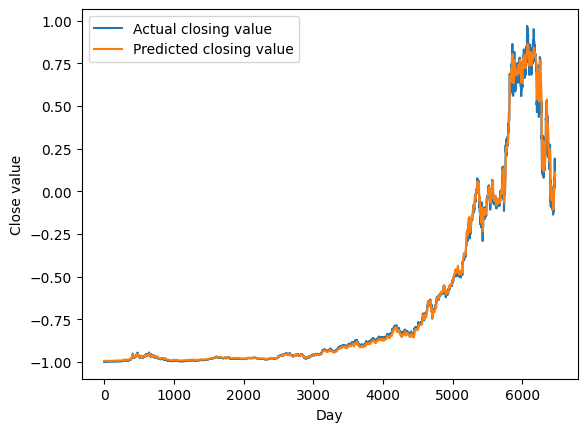

In [22]:
with torch.no_grad():
    train_predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual closing value')
plt.plot(train_predicted, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()

## Rescale data

In [23]:
temp = np.zeros((x_train.shape[0], lookback + 1))
temp[:, 0] = train_predicted.flatten()
temp = scaler.inverse_transform(temp)

rescaled_train_predictions = dc(temp[:, 0])
rescaled_train_predictions

array([  0.64028743,   0.63991483,   0.63941239, ..., 104.29000519,
       103.85369538, 102.9113533 ])

In [24]:
temp = np.zeros((x_train.shape[0], lookback + 1))
temp[:, 0] = y_train.flatten()
temp = scaler.inverse_transform(temp)

rescaled_y_train = dc(temp[:, 0])

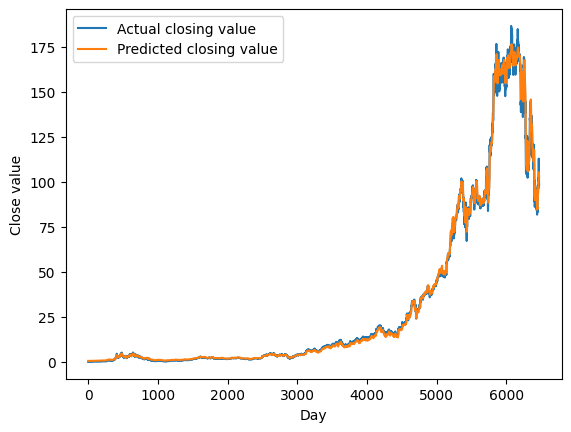

In [25]:
plt.plot(rescaled_y_train, label='Actual closing value')
plt.plot(rescaled_train_predictions, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()

## Plot test results

In [26]:
with torch.no_grad():
    test_predicted = model(x_test.to(device)).cpu().numpy()

temp = np.zeros((x_test.shape[0], lookback + 1))
temp[:, 0] = test_predicted.flatten()
temp = scaler.inverse_transform(temp)

rescaled_test_predictions = dc(temp[:, 0])
rescaled_test_predictions

array([101.55132003, 100.26310015,  99.74636837,  99.62930617,
       100.01908424,  99.39670179,  98.82681124,  97.67635377,
        97.24708451,  96.82150525,  95.77950653,  95.1656021 ,
        94.93892048,  94.15599191,  93.67635202,  94.16102763,
        94.0969012 ,  94.07955209,  94.19514931,  93.75922586,
        93.04458757,  93.06133544,  93.72276168,  94.56568246,
        96.32742788,  97.20321671,  97.58394445,  98.80980509,
        98.98774761,  99.09988559,  98.9497447 ,  98.72815243,
        98.34929262,  99.01262631,  99.86305657, 100.87800805,
       101.35785893, 102.24096282, 102.02855426, 102.25913334,
       102.31704274, 101.61306832, 100.48682286, 101.09487438,
       101.38720811, 101.74971805, 101.88046478, 102.61021129,
       103.02421178, 104.31928733, 104.82647127, 104.1899449 ,
       104.54700206, 106.12980396, 105.81608323, 104.75905143,
       104.4450068 , 104.18163906, 104.16517276, 104.51200111,
       104.6385808 , 105.13456844, 106.62953805, 108.15

In [27]:
temp = np.zeros((x_test.shape[0], lookback + 1))
temp[:, 0] = y_test.flatten()
temp = scaler.inverse_transform(temp)

rescaled_y_test = dc(temp[:, 0])

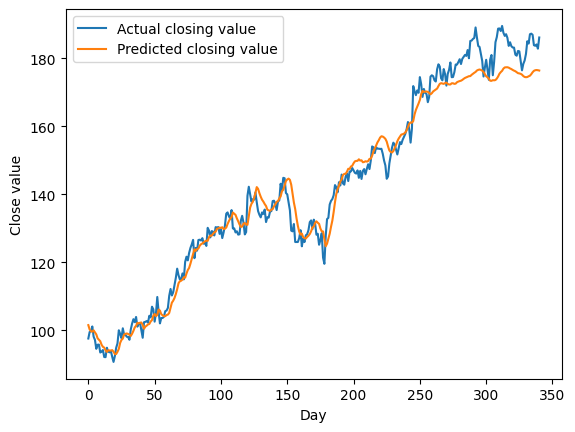

In [28]:
plt.plot(rescaled_y_test, label='Actual closing value')
plt.plot(rescaled_test_predictions, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()